# Исследование зон парковки такси

## Описание проекта.

Данные взяты из датасета размещённого в открытом доступе на https://www.kaggle.com/crailtap/taxi-trajectory 

Это точный набор данных, описывающий полный год (с 01.07.2013 по 30.06.2014) траекторий для всех 442 такси, курсирующих в городе Порту, Португалия. Эти такси работают через диспетчерский пункт такси с использованием мобильных терминалов передачи данных, установленных в транспортных средствах.

Данный проект иллюстирует применение машинного обучения без учителя для анализа популярности зон аренды такси. Сформированные карты могут быть использован как рекомендации для водителей по выбору мест ожидания заказов, а так же оператором такси для оптимизации автопарков каждой станции такси. Для построения карт и анализа количества случаев заказов такси нам потребуется только информация о широте и долготе каждого заказа.

## Описание данных.

TRIP_ID - cодержит уникальный идентификатор для каждой поездки.

CALL_TYPE - определяет способ запроса этой услуги. Он может содержать одно из трех возможных значений: 

- "A", если эта поездка была отправлена из центральной станции; 
- "B", если эта поездка была запрошена непосредственно таксисту на определенной стойке; 
- "C" в противном случае (т.е. требуется поездка по случайной улице).

ORIGINCALL - содержит уникальный идентификатор для каждого телефонного номера, который использовался для запроса хотя бы одной услуги. Он идентифицирует клиента поездки, если CALLTYPE = "A". В противном случае он принимает значение NULL.

ORIGINSTAND - содержит уникальный идентификатор стоянки такси. Он определяет начальную точку поездки, если CALLTYPE = "B". В противном случае он принимает значение NULL.

TAXI_ID - содержит уникальный идентификатор водителя такси, совершавшего каждую поездку.

TIMESTAMP - временная метка Unix (в секундах). Он определяет начало поездки.

DAYTYPE - определяет тип дня начала поездки. Он принимает одно из трех возможных значений: 

- "B", если эта поездка началась в праздничный или любой другой особый день (например, продление праздников, плавающие праздники и т. Д.); 
- "C", если поездка началась за день до дня типа B; 
- "А" в противном случае (т.е. обычный день, рабочий день или выходные).

MISSING_DATA - это False , когда поток данных GPS завершен, и True, если одно (или несколько) местоположений отсутствует.

POLYLINE - он содержит список координат GPS (например, в формате WGS84), отображаемых в виде строки. Начало и конец строки обозначаются скобками. Каждая пара координат также обозначается теми же скобками. Этот список содержит одну пару координат на каждые 15 секунд поездки. Последний элемент списка соответствует пункту назначения поездки, а первый - ее началу.


Общее время поездки определяется как количество координат x 15 секунд. Например, поездка со 101 точкой данных в POLYLINE имеет длину (101-1) * 15 = 1500 секунд. В некоторых поездках отсутствуют точки данных в POLYLINE, обозначенные столбцом MISSING_DATA.

### Импорты и подготовка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from shapely.geometry import Polygon, LineString

from shapely.geometry import Polygon, LineString
import geopandas
import folium
from folium import plugins
from geojson import FeatureCollection, dump
import json

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


Признак POLYLINE представлен в виде строки, предстаким его в виде списка списков.

In [5]:
def list_maker(row):
    coords = pd.to_numeric(re.sub(r'[^.0-9]', ' ', row).split())
    latitude = coords[1::2]
    longitude = coords[::2] * -1
    d = []
    for i in range(0, len(latitude)):
        d.append((latitude[i], longitude[i]))
    return d

data['line'] = data['POLYLINE'].apply(list_maker)

In [6]:
data['line'].head()

0    [(41.141412, -8.618643), (41.141376, -8.618499...
1    [(41.159826, -8.639847), (41.159871, -8.640351...
2    [(41.140359, -8.612964), (41.14035, -8.613378)...
3    [(41.151951, -8.574678), (41.151942, -8.574705...
4    [(41.18049, -8.645994), (41.180517, -8.645949)...
Name: line, dtype: object

Мы получили наборы координат. Т.к. мы будем строить карту состоявшихся поездок, проверим, чтоб мы работали только с данными содержащими более одного набора координат.

In [7]:
data['len_line'] = data['line'].apply(lambda x: len(x))

In [8]:
print('Количество строк без координат или только с одной', len(data[data['len_line'] <= 1].reset_index(drop=True)))

Количество строк без координат или только с одной 36510


Удалим их.

In [9]:
data  = data[data['len_line'] > 1].reset_index(drop=True)

Извлечём в отдельне столбцы долготу и широту начала поедки.

In [10]:
data['start_latitude'] = data['line'].apply(lambda x: x[0][0])
data['start_latitude'].head()

0    41.141412
1    41.159826
2    41.140359
3    41.151951
4    41.180490
Name: start_latitude, dtype: float64

In [11]:
data['start_longitude'] = data['line'].apply(lambda x: x[0][1])
data['start_longitude'].head()

0   -8.618643
1   -8.639847
2   -8.612964
3   -8.574678
4   -8.645994
Name: start_longitude, dtype: float64

### Исследовательский анализ

Для построения карт и анализа количества случаев заказов такси нам потребуется только информация о широте и долготе каждого заказа. Округлим эти данные до 4 знаков после запятой.

In [12]:
round_four = data[['start_latitude', 'start_longitude']].round(4)

Посчитаем количество случаев парковки в каждой точке координат.

In [13]:
rent_count = (pd.DataFrame(round_four[['start_latitude','start_longitude']]
                           .value_counts()
                           .sort_values(), 
                           columns=['count'])
              .reset_index())

Оценим распределение количесва заказов такси по широте и долготе.

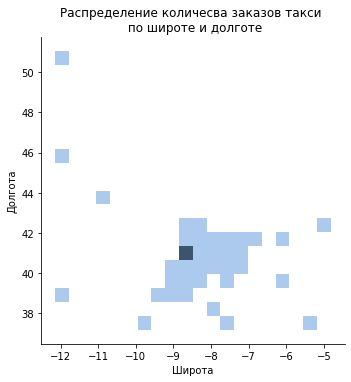

In [14]:
sns.displot(data=rent_count, x='start_longitude', y='start_latitude', bins=20)
plt.title('Распределение количесва заказов такси \n по широте и долготе')
plt.xlabel('Широта')
plt.ylabel('Долгота')
plt.show()

На графике видно, что некоторые поездки начинались далеко за пределами основной части заказов. Т.к. мы оцениваем ситуацию именно для города Порто, определим с какими именно диапазонами широты и долготы мы будем работать.

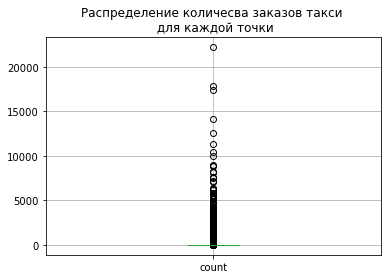

In [15]:
rent_count.boxplot('count')
plt.title('Распределение количесва заказов такси \n для каждой точки')
plt.show()

В дынных большое количество выбросов, это точки координат с большим количеством заказов. Нас интересуют именно такие аномальне значения. 

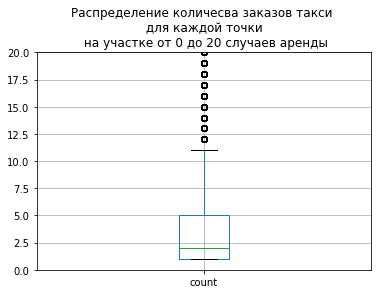

In [16]:
rent_count.boxplot('count')
plt.ylim(0, 20)
plt.title('Распределение количесва заказов такси \n для каждой точки \n на участке от 0 до 20 случаев аренды')
plt.show()

Будем использовать координаты которые для начала поездки за год использовали более 11 раз.

In [17]:
map_df = rent_count[rent_count['count'] >= 11].reset_index(drop=True)

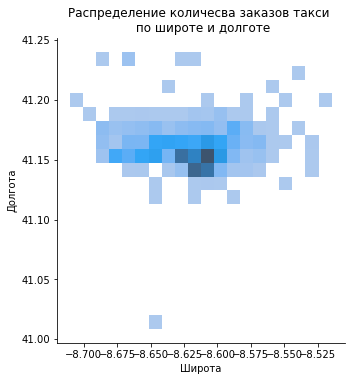

In [18]:
sns.displot(data=map_df, x='start_longitude', y='start_latitude', bins=20)
plt.title('Распределение количесва заказов такси \n по широте и долготе')
plt.xlabel('Широта')
plt.ylabel('Долгота')
plt.show()

Мы значительно сократили количество непопулярных мест парковки, но на графике всё еще есть удалённые точки, которые выходят за пределы значимой для нас выборки. Изучим распределения по широте и долготе отдельно и обрежем нашу карту до оптимальных диападонов.

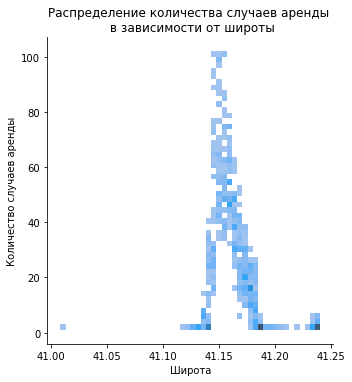

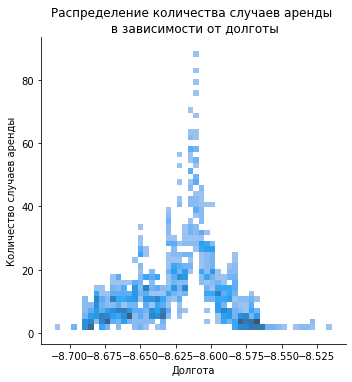

In [19]:
latitude = pd.DataFrame(map_df['start_latitude'].value_counts()).reset_index()
latitude.columns = ['start_latitude', 'count']
sns.displot(data=latitude, x='start_latitude', y='count', bins=50)
plt.title('Распределение количества случаев аренды \n в зависимости от широты')
plt.xlabel('Широта')
plt.ylabel('Количество случаев аренды')
plt.show()

longitude = pd.DataFrame(map_df['start_longitude'].value_counts()).reset_index()
longitude.columns = ['start_longitude', 'count']
sns.displot(data=longitude, x='start_longitude', y='count', bins=50)
plt.title('Распределение количества случаев аренды \n в зависимости от долготы')
plt.xlabel('Долгота')
plt.ylabel('Количество случаев аренды')
plt.show()

In [20]:
map_df = map_df[(map_df['start_latitude'] >= 41.13) & (map_df['start_latitude'] <= 41.19)].reset_index(drop=True)
map_df = map_df[(map_df['start_longitude'] >= -8.69) & (map_df['start_longitude'] <= -8.56)].reset_index(drop=True)

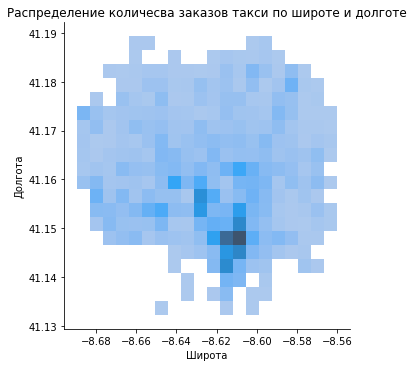

In [21]:
sns.displot(data=map_df, x='start_longitude', y='start_latitude', bins=20)
plt.title('Распределение количесва заказов такси по широте и долготе')
plt.xlabel('Широта')
plt.ylabel('Долгота')
plt.show()

Данные готовы к построению карт.

### Построение интерактивных карт.

Наша задача выбрать оптимальный способ отображения количества начала поездок на карте.

#### Тепловая карта

In [22]:
m = folium.Map(location=[41.1605, -8.6218], tiles="CartoDB positron", zoom_start=13)
folium.plugins.HeatMap(data=map_df, radius=12).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
m

In [23]:
m.save(outfile= "porto_heat.html")

Тепловая карта отражает, что в городе действительно есть зоны где такси более восстребованны. Однако выделить районы по загруженности мы не можем. Выделим 30 крупных районов с помошью KMeans.

#### 30 крурных зон

In [24]:
# Деление карты на кластеры

locations = map_df[['start_latitude', 'start_longitude']]
model = KMeans(n_clusters=30, random_state=12345)
model.fit(locations)
map_df['label'] = model.labels_
features = []

# Запись словаря

for i in range(0, len(map_df['label'].value_counts())):
    claster = map_df[map_df['label'] == i]
    set_of_points = claster[['start_longitude', 'start_latitude']]
    if len(set_of_points) >= 3:
        try:
            polygon = np.array(Polygon(set_of_points.values).convex_hull.exterior.coords)
        except:
            polygon = np.array(LineString(set_of_points.values).coords)
        dicts = { "type": "Feature",
                 "geometry": {"type": "Polygon",
                              "coordinates": [polygon.tolist()]},
                              "properties": {"name": "{}".format(i),
                                            "count": claster['count'].median()}
                             }
        features.append(dicts)
            
feature_collection = FeatureCollection(features)

# Запись json файла

with open('porto_zone.json', 'w') as f:
    json.dump(feature_collection, f)

# Запись geopandas

filename = "porto_zone.json"
file = open(filename)
df = geopandas.read_file(file)

# Построение карты

porto_zone = df.explore(location=[41.1605, -8.6218],
                        zoom_start=13,
                        column='count',
                        tiles="CartoDB positron",
                        cmap="viridis_r")
porto_zone

In [25]:
porto_zone.save(outfile= "porto_zone.html")

Данный тип карты более наглядно отражает районы и их медианное значение количества заказов такси.

#### Каждая координата

Однако хотелось бы исследовать город более детально. Посмотрим на сколько информативной будет карта ести отобразить на ней каждую точку с количеством заказов.

In [ ]:
features = []

for i in range(0, map_df.shape[0]):
    dicts ={
              "type": "Feature",
              "geometry": {
                  "type": "Point",
                  "coordinates": map_df[['start_longitude', 'start_latitude']].loc[i].tolist()},
              "properties": {"count": map_df['count'].loc[i].tolist()}
            }
    features.append(dicts)

collection = FeatureCollection(features)

with open('porto_point.json', 'w') as f:
    json.dump(collection, f)
    
filename = "porto_point.json"
file = open(filename)
df = geopandas.read_file(file)

df['geometry'] = df['geometry'].to_crs(3857).buffer(6)

porto_point = df.explore(location=[41.1464, -8.6113],
                         zoom_start=17,
                         column='count',
                         tiles="CartoDB positron",
                         cmap="viridis_r")
porto_point

In [ ]:
porto_point.save(outfile= "porto_point.html")

Очень хорошо видны самые популярные точки, но хотелось бы, чтобы карта отображала и плотность этих точек, а так же была компактной. Снова обратимся к алгогиртмам класстеризации. На этот раз разделим данные на 100 зон с помощью K-Means, а затем с помощью AgglomerativeClustering подберём оптимальное количество кластеров для каждой зоны. AgglomerativeClustering хорошо улавливает форму кластеров вдоль дороги, но очень долго обрабатывает большое количество данных, с помощбю K-Means мы сократим время работы.

#### Карта малых полигонов

In [27]:
locations = map_df[['start_latitude', 'start_longitude']]

model = KMeans(n_clusters=100, random_state=12345)
model.fit(locations)

map_df['label'] = model.labels_

features = []

for p in range(0, 100):
    zone = map_df[map_df['label'] == p]
    coordinates = zone[['start_latitude', 'start_longitude']]
    if len(coordinates) >= 2:
        model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.005).fit(coordinates)
        zone['label'] = model.labels_
        for i in range(0, len(zone['label'].value_counts())):
            claster = zone[zone['label'] == i]
            set_of_points = claster[['start_longitude', 'start_latitude']]
            if len(set_of_points) >= 3:
                try:
                    polygon = np.array(Polygon(set_of_points.values).convex_hull.exterior.coords)
                except:
                    polygon = np.array(LineString(set_of_points.values).coords)
                dicts = { "type": "Feature",
                              "geometry": {"type": "Polygon",
                                           "coordinates": [polygon.tolist()]},
                              "properties": {"name": "{}_{}".format(p, i),
                                            "count": claster['count'].median()}
                             }
                features.append(dicts)
            
feature_collection = FeatureCollection(features)

with open('porto_polygon.json', 'w') as f:
    json.dump(feature_collection, f)
    
filename = "porto_polygon.json"
file = open(filename)
df = geopandas.read_file(file)

porto_polygon = df.explore(location=[41.1464, -8.6113],
                           zoom_start=17,
                           column='count',
                           tiles="CartoDB positron",
                           cmap="viridis_r")
porto_polygon

In [28]:
porto_polygon.save(outfile= "porto_polygon.html")

### Выводы

В данном проекте мы реализовали несколько видов карт, которые могут помочь в оптимизации стоянок автопарка такси города Порто.